In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.neural_network import MLPClassifier
     
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import json
import os
import re

import gensim 
from gensim.models import Word2Vec
import gensim.downloader

import pickle 

import nltk
from nltk.tokenize import word_tokenize

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /homes/lgf21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
tqdm.pandas()

In [30]:
#cp ../src/rcatt_training_data_original.csv .

# Opening Files: 

In [4]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [5]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

In [6]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

# Merging Files: 

In [7]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tactic_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [8]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('TA')]]

In [9]:
Y1 = Y_s[Y_r.columns]
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the tactic in Y1

# Pre-processing: 

In [9]:
# Open Pickle: 

with open('lemma_preprocessing.pickle', 'rb') as handle:
    tac_preprocessing = pickle.load(handle)

In [134]:
np.mean(list(map(len, X_r))) # length of text - average 21,542 words 

21542.208588957055

In [10]:
nlp = spacy.load("en_core_web_sm", disable=['ner']) 

In [11]:
# Lemmatisation: 

df = pd.DataFrame({"text": X_r})
df['lemma'] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))


In [100]:
# Stemming: 

#stemmer = SnowballStemmer(language='english')
#df['stemmer'] = df['text'].apply(lambda x: " ".join([stemmer.stem(token) for token in x]))


In [138]:
# Save as pickle: 

with open('lemma_preprocessing.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Split dataset: 

In [10]:
# change x train to df['lemma'] or X_r #


X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(X_r, Y_r, test_size=0.3,
                                                    random_state = 10)

In [11]:
X_train_text = pd.concat([X_r_train, X_s])

In [12]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

# Feature Extraction:

In [13]:
def feature_extraction(featureExtract, X_train_text, X_test_text, average = False):
    if featureExtract in ['CountVectorizer', 'TfIdfVectorizer']:
        if featureExtract== 'CountVectorizer':
            fe = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 2, max_df = 0.99) # if words used less than 0.001 % and in less than 2 documents --> ignore  
        else:
            fe = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df=0.99)
        
        X_train = fe.fit_transform(X_train_text)
        X_train = pd.DataFrame(X_train.toarray(), columns = fe.get_feature_names()) 
        X_test = fe.transform(X_test_text)
        X_test = pd.DataFrame(X_test.toarray(), columns = fe.get_feature_names())
    
    else:
        model = gensim.downloader.load(featureExtract)
        # sent is tokenised sentence on which we do the embedding
        def get_embeddings(sent):
            # if text not in vocab:
            words_in_vocab = [word for word in sent if word in model]
            if not words_in_vocab:
                return np.zeros_like(model['the'])
            emb = model[words_in_vocab]
            return np.mean(emb, axis=0) if average else np.sum(emb, axis=0)
        #perform tokenisation
        X_train = pd.DataFrame(X_train_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
        X_test = pd.DataFrame(X_test_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
    return X_train, X_test
        
        
        

In [14]:
#X_train, X_test = feature_extraction('CountVectorizer', X_train_text, X_test_text)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
X_train, X_test = feature_extraction('TfIdfVectorizer', X_train_text, X_test_text)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
#X_train, X_test = feature_extraction('word2vec-google-news-300', X_train_text, X_test_text)

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.1% 68.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.4% 139.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.2% 186.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 14.0% 232.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.8% 278.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.5% 324.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.1% 367.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.4% 438.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.1% 516.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.0% 582.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 39.2% 652.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 44.0% 731.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.5% 790.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 52.2% 868.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.2% 934.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.9% 979.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.7% 1025.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.7% 1059.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.9% 1096.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.3% 1136.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.9% 1179.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.6% 1223.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.1% 1265.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.7% 1308.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.4% 1353.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.1% 1398.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.8% 1443.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.4% 1487.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.4% 1552.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.1% 1631.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00, 214.70it/s]


In [18]:
# ---------------- Word2Vec ---------------------: 

#glove = gensim.downloader.load('glove-wiki-gigaword-100')


In [ ]:
# ---------------- Glove ---------------------: 

# load the whole embedding into memory
#embeddings_index = dict()
#f = open('../data/glove/glove.6B.100d.txt')

# loop through each lines as key, values as coefficients
#for line in f:
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs 

#f.close()

#X_train = df['lemma'].apply(lambda x: [embeddings_index[word] for word in x]) 


In [216]:
X_train, X_test = feature_extraction('glove-wiki-gigaword-100', X_train_text, X_test_text)

100%|██████████| 441/441 [00:04<00:00, 88.96it/s] 


In [61]:
X_train.shape

(2229, 74675)

In [62]:
Y_train.shape

(2229, 12)

In [63]:
X_train_text.shape

(2229,)

In [57]:
Y_train

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0
4,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2371,1,1,0,1,1,1,1,0,1,1,1,1
2372,0,1,0,1,1,0,1,0,0,0,1,0
2373,0,0,0,0,0,0,0,0,0,0,1,0
2374,0,1,0,1,0,0,1,0,1,1,1,0


In [53]:
Y_train

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0
4,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2371,1,1,0,1,1,1,1,0,1,1,1,1
2372,0,1,0,1,1,0,1,0,0,0,1,0
2373,0,0,0,0,0,0,0,0,0,0,1,0
2374,0,1,0,1,0,0,1,0,1,1,1,0


## Train Word2Vec on CTI Reports:

In [56]:
X_train_text = X_train_text.reset_index()['Text']

# Measuring Cosine Similarity to Remove Duplicates: 

In [17]:
similarities = cosine_similarity(X_train, X_test)

In [18]:
duplicates = set()
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            # print(i, j, similarities[i][j])
            duplicates.add(i)

In [19]:
X_train_text = X_train_text[~X_train_text.index.isin(duplicates)]
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

# Visualisation:

<AxesSubplot:>

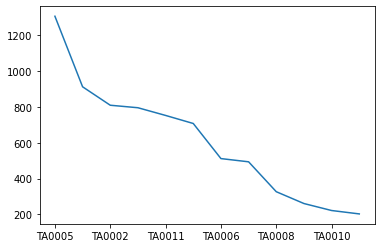

In [20]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

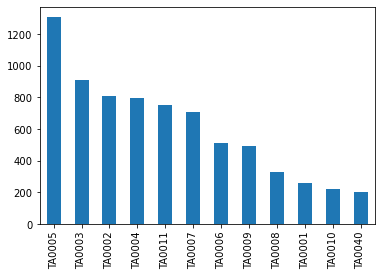

In [21]:
Y_train.sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [288]:
# TSNE using vector from glove: 

X = list(X_train.values)
X_embedded = TSNE(n_components=2).fit_transform(X)

df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label= Y_train)

ValueError: Expected a 1D array, got an array with shape (2229, 12)

In [ ]:
fig = px.scatter(
    df_embeddings, x ='tactic', y ='text',
    color='label', labels={'color': 'label'}
    hover_data=['text'], title = 'GoEmotions Embedding Visualization')
fig.show()

# Evaluation:

In [23]:
def evaluation(Y_pred, Y_test):
    macro_precision = precision_score(Y_test, Y_pred, average ='macro')
    micro_precision = precision_score(Y_test, Y_pred, average ='micro')
    macro_recall = recall_score(Y_test, Y_pred, average='macro')
    micro_recall = recall_score(Y_test, Y_pred, average='micro')
    macro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')
    micro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')
    l_metric = ['macro precision', 'micro precision', 'macro recall', 'micro recall', 'macro fscore', 'micro fscore']
    l_result = [macro_precision, micro_precision, macro_recall, micro_recall, macro_fscore, micro_fscore]
    df_res = pd.DataFrame({'metric': l_metric, 'result': l_result})
    return df_res

## Naive Bayes:

In [80]:
naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [81]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(X_test), columns = Y_test.columns)

In [82]:
y_pred = (y_pred_proba > 0.005).astype(int) # if increase threshold, recall decreases and precision (could) increase

In [83]:
evaluation(y_pred, Y_test)

,metric,result
0,macro precision,0.666805
1,micro precision,0.423497
2,macro recall,0.306688
3,micro recall,0.253475
4,macro fscore,0.382681
5,micro fscore,0.373404


## SVC:

In [24]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [25]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

In [26]:
evaluation(Y_pred, Y_test)

,metric,result
0,macro precision,0.666731
1,micro precision,0.705984
2,macro recall,0.640867
3,micro recall,0.665576
4,macro fscore,0.660490
5,micro fscore,0.697515


## Multi-label KNN: 

In [226]:
knn = MLkNN(k = 3)

In [227]:
# train
knn.fit(X_train.values, Y_train.values)

# predict
predictions = knn.predict(X_test.values)

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [233]:
evaluation(predictions, Y_test)

0.3973834832379395

## Logistic Regression:

In [ ]:
# reduce dimension using pca: 

pca = PCA(n_components=150)
pca.fit(X_train)
pca_result = pca.transform(X_train)
x_test_result = pca.transform(X_test )

In [290]:
X_train.shape

(2229, 8446)

In [ ]:
log_reg = OneVsRestClassifier(LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs', max_iter = 1000)).fit(X_train, Y_train)

predictions = log_reg.predict(X_test)


In [ ]:
evaluation(predictions, Y_test)

## DT AdaBoost: 

In [71]:
dt_adaboost = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train, Y_train)
predictions_ada = dt_adaboost.predict(X_test)

KeyboardInterrupt: 

In [ ]:
evaluation(predictions_ada, Y_test)

# Classifer Chain: 

In [ ]:
def chain_model(model):
    model_chain = ClassifierChain(model, order='random', random_state=0)
    return model_chain

In [89]:
#chain = chain_model(naive_bayes_classifier) # change model appropriately

In [ ]:
chain = chain_model(log_reg) # change model appropriately

In [ ]:
chainModel = chain.fit(X_train.values, Y_train.values)
predictions = chainModel.predict(X_test.values)

In [ ]:
evaluation(predictions, Y_test)

# Neural Networks:

## Multi Layer Perceptron: 

In [43]:
mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, Y_train)

In [44]:
predictions_mlp = mlp.predict(X_test)

In [48]:
evaluation(predictions_mlp, Y_test)

,metric,result
0,macro precision,0.715035
1,micro precision,0.728484
2,macro recall,0.526173
3,micro recall,0.581357
4,macro fscore,0.658048
5,micro fscore,0.693388


## Transformers:

In [23]:
with open('fasttext_format_train.txt', 'w') as file:
    for i in range(len(Y_train)):
        file.write(' '.join(['__label__'+col for col in Y_train.columns if Y_train.iloc[i][col] == 1]) + ' ' + X_train_text.iloc[i] + '\n')

IndexError: single positional indexer is out-of-bounds

In [15]:
with open('fasttext_format_test.txt', 'w') as file:
    for i in range(len(Y_test)):
        file.write(' '.join(['__label__'+col for col in Y_test.columns if Y_test.iloc[i][col] == 1]) + ' ' + X_test_text.iloc[i] + '\n')

In [16]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

# this is the folder in which train, test and dev files reside
data_folder = '.'

# load corpus containing training, test and dev data
corpus = ClassificationCorpus(data_folder,
                                      test_file='fasttext_format_test.txt',
                                      dev_file='fasttext_format_test.txt',
                                      train_file='fasttext_format_train.txt',
                                      label_type='tactic',
                                      )

2022-07-19 16:10:26,898 Reading data from .
2022-07-19 16:10:26,898 Train: fasttext_format_train.txt
2022-07-19 16:10:26,899 Dev: fasttext_format_test.txt
2022-07-19 16:10:26,900 Test: fasttext_format_test.txt
2022-07-19 16:10:27,630 Initialized corpus . (label type name is 'tactic')


In [17]:
# 2. what label do we want to predict?
label_type = 'tactic'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

2022-07-19 16:10:27,633 Computing label dictionary. Progress:


2152it [02:25, 14.75it/s]

2022-07-19 16:12:53,748 Dictionary created for label 'tactic' with 13 values: TA0005 (seen 1237 times), TA0003 (seen 857 times), TA0002 (seen 756 times), TA0004 (seen 742 times), TA0011 (seen 688 times), TA0007 (seen 659 times), TA0006 (seen 487 times), TA0009 (seen 465 times), TA0008 (seen 312 times), TA0001 (seen 248 times), TA0010 (seen 199 times), TA0040 (seen 190 times)


In [ ]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import flair
flair.device = 'cpu'


# 4. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('binay1999/text_classification_cybertexts', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type, multi_label=True)

# 6. initialize trainer
trainer = ModelTrainer(classifier, corpus)

# 7. run training with fine-tuning
trainer.fine_tune('test_model',
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=10,
                  )

2022-07-19 16:13:01,676 ----------------------------------------------------------------------------------------------------
2022-07-19 16:13:01,677 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=13, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): BCEWithLogitsLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_feat

2022-07-19 16:27:43,274 epoch 1 - iter 265/538 - loss 0.14366906 - samples/sec: 1.33 - lr: 0.000025
2022-07-19 16:30:30,713 epoch 1 - iter 318/538 - loss 0.13414120 - samples/sec: 1.33 - lr: 0.000030
2022-07-19 16:33:21,932 epoch 1 - iter 371/538 - loss 0.12586894 - samples/sec: 1.29 - lr: 0.000034
2022-07-19 16:36:15,479 epoch 1 - iter 424/538 - loss 0.12517075 - samples/sec: 1.32 - lr: 0.000039
2022-07-19 16:39:42,741 epoch 1 - iter 477/538 - loss 0.12697850 - samples/sec: 1.23 - lr: 0.000044
2022-07-19 16:43:03,794 epoch 1 - iter 530/538 - loss 0.12765312 - samples/sec: 1.23 - lr: 0.000049
2022-07-19 16:43:29,522 ----------------------------------------------------------------------------------------------------
2022-07-19 16:43:29,524 EPOCH 1 done: loss 0.1276 - lr 0.000049


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:01<00:00,  1.10s/it]


2022-07-19 16:45:31,498 Evaluating as a multi-label problem: True
2022-07-19 16:45:31,620 DEV : loss 0.169650137424469 - f1-score (micro avg)  0.426
2022-07-19 16:45:54,825 BAD EPOCHS (no improvement): 4
2022-07-19 16:45:54,827 ----------------------------------------------------------------------------------------------------
2022-07-19 16:48:54,714 epoch 2 - iter 53/538 - loss 0.12661027 - samples/sec: 1.31 - lr: 0.000049
2022-07-19 16:51:52,589 epoch 2 - iter 106/538 - loss 0.12676938 - samples/sec: 1.30 - lr: 0.000049
2022-07-19 16:54:51,730 epoch 2 - iter 159/538 - loss 0.12860924 - samples/sec: 1.30 - lr: 0.000048
2022-07-19 17:01:04,196 epoch 2 - iter 265/538 - loss 0.12650177 - samples/sec: 1.27 - lr: 0.000047
2022-07-19 17:03:59,598 epoch 2 - iter 318/538 - loss 0.12615634 - samples/sec: 1.32 - lr: 0.000047
2022-07-19 17:06:58,127 epoch 2 - iter 371/538 - loss 0.12644815 - samples/sec: 1.29 - lr: 0.000046
2022-07-19 17:09:56,520 epoch 2 - iter 424/538 - loss 0.12622420 - sampl

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:07<00:00,  1.15s/it]


2022-07-19 17:18:57,249 Evaluating as a multi-label problem: True
2022-07-19 17:18:57,269 DEV : loss 0.11882007122039795 - f1-score (micro avg)  0.0
2022-07-19 17:19:20,454 BAD EPOCHS (no improvement): 4
2022-07-19 17:19:20,456 ----------------------------------------------------------------------------------------------------
2022-07-19 17:22:10,103 epoch 3 - iter 53/538 - loss 0.12278324 - samples/sec: 1.34 - lr: 0.000044
2022-07-19 17:25:09,186 epoch 3 - iter 106/538 - loss 0.12230715 - samples/sec: 1.28 - lr: 0.000043
2022-07-19 17:28:09,745 epoch 3 - iter 159/538 - loss 0.12452948 - samples/sec: 1.27 - lr: 0.000043
2022-07-19 17:31:09,125 epoch 3 - iter 212/538 - loss 0.12468780 - samples/sec: 1.27 - lr: 0.000042
2022-07-19 17:34:00,697 epoch 3 - iter 265/538 - loss 0.12550708 - samples/sec: 1.33 - lr: 0.000042
2022-07-19 17:37:14,621 epoch 3 - iter 318/538 - loss 0.12476152 - samples/sec: 1.21 - lr: 0.000041
2022-07-19 17:42:12,159 epoch 3 - iter 371/538 - loss 0.12419336 - sampl

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:01<00:00,  1.09s/it]


2022-07-19 17:55:26,540 Evaluating as a multi-label problem: True
2022-07-19 17:55:26,567 DEV : loss 0.11838854104280472 - f1-score (micro avg)  0.2569
2022-07-19 17:55:49,595 BAD EPOCHS (no improvement): 4
2022-07-19 17:55:49,597 ----------------------------------------------------------------------------------------------------
2022-07-19 17:58:45,812 epoch 4 - iter 53/538 - loss 0.12029103 - samples/sec: 1.31 - lr: 0.000038
2022-07-19 18:02:16,364 epoch 4 - iter 106/538 - loss 0.12178642 - samples/sec: 1.10 - lr: 0.000038
2022-07-19 18:06:20,595 epoch 4 - iter 159/538 - loss 0.12172935 - samples/sec: 0.92 - lr: 0.000037
2022-07-19 18:10:13,258 epoch 4 - iter 212/538 - loss 0.12370101 - samples/sec: 0.98 - lr: 0.000037
2022-07-19 18:13:19,821 epoch 4 - iter 265/538 - loss 0.12279922 - samples/sec: 1.26 - lr: 0.000036
2022-07-19 18:16:24,818 epoch 4 - iter 318/538 - loss 0.12305298 - samples/sec: 1.29 - lr: 0.000036
2022-07-19 18:19:41,356 epoch 4 - iter 371/538 - loss 0.12190048 - sa

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:03<00:00,  1.11s/it]

2022-07-19 18:31:31,032 Evaluating as a multi-label problem: True
2022-07-19 18:31:31,130 DEV : loss 0.11638229340314865 - f1-score (micro avg)  0.2671


2022-07-19 18:31:54,068 BAD EPOCHS (no improvement): 4
2022-07-19 18:31:54,070 ----------------------------------------------------------------------------------------------------
2022-07-19 18:34:50,514 epoch 5 - iter 53/538 - loss 0.11813065 - samples/sec: 1.31 - lr: 0.000033
2022-07-19 18:38:14,935 epoch 5 - iter 106/538 - loss 0.12184502 - samples/sec: 1.15 - lr: 0.000032
2022-07-19 18:41:44,410 epoch 5 - iter 159/538 - loss 0.12168713 - samples/sec: 1.06 - lr: 0.000032
2022-07-19 18:44:33,998 epoch 5 - iter 212/538 - loss 0.12060816 - samples/sec: 1.33 - lr: 0.000031
2022-07-19 18:47:30,742 epoch 5 - iter 265/538 - loss 0.12036655 - samples/sec: 1.29 - lr: 0.000031
2022-07-19 18:50:29,786 epoch 5 - iter 318/538 - loss 0.11988611 - samples/sec: 1.30 - lr: 0.000030
2022-07-19 18:53:30,965 epoch 5 - iter 371/538 - loss 0.12009452 - samples/sec: 1.30 - lr: 0.000030
2022-07-19 18:56:37,430 epoch 5 - iter 424/538 - loss 0.12030502 - samples/sec: 1.28 - lr: 0.000029
2022-07-19 18:59:44,7

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:24<00:00,  1.31s/it]


2022-07-19 19:05:33,066 Evaluating as a multi-label problem: True
2022-07-19 19:05:33,097 DEV : loss 0.11643009632825851 - f1-score (micro avg)  0.2579
2022-07-19 19:05:56,604 BAD EPOCHS (no improvement): 4
2022-07-19 19:05:56,606 ----------------------------------------------------------------------------------------------------
2022-07-19 19:09:14,145 epoch 6 - iter 53/538 - loss 0.11530504 - samples/sec: 1.14 - lr: 0.000027
2022-07-19 19:12:23,462 epoch 6 - iter 106/538 - loss 0.11499505 - samples/sec: 1.28 - lr: 0.000027
2022-07-19 19:15:25,713 epoch 6 - iter 159/538 - loss 0.11803697 - samples/sec: 1.27 - lr: 0.000026
2022-07-19 19:18:34,641 epoch 6 - iter 212/538 - loss 0.11779030 - samples/sec: 1.27 - lr: 0.000026
2022-07-19 19:21:34,187 epoch 6 - iter 265/538 - loss 0.11795689 - samples/sec: 1.28 - lr: 0.000025
2022-07-19 19:24:34,094 epoch 6 - iter 318/538 - loss 0.11844543 - samples/sec: 1.26 - lr: 0.000025
2022-07-19 19:27:30,178 epoch 6 - iter 371/538 - loss 0.11779001 - sa

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [02:29<00:00,  1.35s/it]

2022-07-19 19:39:54,654 Evaluating as a multi-label problem: True
2022-07-19 19:39:54,674 DEV : loss 0.11708489805459976 - f1-score (micro avg)  0.0033


2022-07-19 19:40:18,714 BAD EPOCHS (no improvement): 4
2022-07-19 19:40:18,716 ----------------------------------------------------------------------------------------------------
2022-07-19 19:43:17,390 epoch 7 - iter 53/538 - loss 0.10714586 - samples/sec: 1.27 - lr: 0.000022
2022-07-19 19:46:18,027 epoch 7 - iter 106/538 - loss 0.10868853 - samples/sec: 1.26 - lr: 0.000021
2022-07-19 19:49:14,851 epoch 7 - iter 159/538 - loss 0.10960608 - samples/sec: 1.30 - lr: 0.000021
2022-07-19 19:52:30,085 epoch 7 - iter 212/538 - loss 0.11198761 - samples/sec: 1.16 - lr: 0.000020
2022-07-19 19:55:34,246 epoch 7 - iter 265/538 - loss 0.11249767 - samples/sec: 1.29 - lr: 0.000020
2022-07-19 19:58:31,787 epoch 7 - iter 318/538 - loss 0.11246734 - samples/sec: 1.31 - lr: 0.000019
2022-07-19 20:01:44,287 epoch 7 - iter 371/538 - loss 0.11296731 - samples/sec: 1.25 - lr: 0.000018
